# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions, providing the python code in the cell below.

In [3]:
df = pd.read_csv('footballer_data.csv')

# Drop the columns
df = df.drop(columns = ['ID', 'club', 'club_logo', 'birth_date', 'flag', 'nationality', 'photo', 'potential'])

# Hint: In order to get dummies, you can first convert the column with strings to Categorical type using pandas,
# using a specific set of categories
df['work_rate_att'] = pd.Categorical(df.work_rate_att)
df['work_rate_def'] = pd.Categorical(df.work_rate_def)
df['work_rate_att'] = pd.Categorical(df.work_rate_att)

df = pd.get_dummies(df, prefix = ['work_rate_att', 'work_rate_def', 'preferred_foot'], columns = ['work_rate_att', 'work_rate_def', 'preferred_foot'])


In [4]:
df.head()

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_High,work_rate_att_Low,work_rate_att_Medium,work_rate_def_High,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Left,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,1,0,0,0,1,0,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,0,1,0,0,1,1,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,1,0,0,0,0,1,0,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,1,0,0,0,0,1,0,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,0,0,1,0,0,1,0,1


### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors on the original data that result if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the losses (absolute errors) and print their mean and standard deviation.

In [5]:
# creating the function that returns mean absolute error
import statistics

def MAE(actual, calculated):
    abs_error = abs(actual - calculated)
    mean_error = statistics.mean(abs_error)
    return mean_error

def STDE(actual, calculated):
    abs_error = abs(actual - calculated)
    std_error = statistics.stdev(abs_error)
    return std_error

The mean of the loss is: 5.491330443481161 
The standard deviation of the loss is: 4.262004616587558


/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overall', ylabel='Density'>

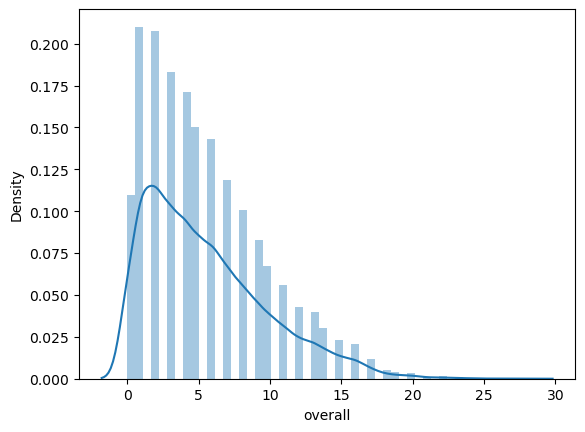

In [6]:
# Get mean and std of test loss 
mean_error_overall = MAE(df['overall'], statistics.median(df['overall']))
std_testloss = STDE(df['overall'], statistics.median(df['overall']))

print("The mean of the loss is:", mean_error_overall, "\nThe standard deviation of the loss is:", std_testloss)

# Plot distribution
abs_error = abs(df['overall'] - statistics.median(df['overall']))
sns.distplot(abs_error)

### Question 3: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like you to choose the test set size so that the estimate of the performance of the final selected model is known to within $\pm 0.25$ units at a 95% confidence interval, using mean absolute error as the loss function of choice.

Recall that a CLT-based $95\%$ confidence interval for a mean is given by:

$ \bar{x} \pm \frac{1.96 \sigma_l}{\sqrt{n}}$,

If we equate the right hand side to $d$ and re-arrange, we can choose the test set size using the following formula, which gives the test size ($n_\mathrm{test}$) needed for a confidence interval to have width ($\pm d$) if the standard deviation of the loss is $\sigma_l$:

$ n_\textrm{test} = \left(\frac{1.96 \sigma_l}{d}\right)^2$.

Decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [7]:
d = 0.25
z = 1.96
sigma = std_testloss
n_test = int((1.96*std_testloss/d)**2)

X = df.drop('overall', axis = 'columns')

y = df['overall']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = n_test, random_state = 0)
print(Xtrain.shape, Xtest.shape)

(16878, 48) (1116, 48)


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [8]:
model1 = Pipeline([
    ('linear_regression', LinearRegression())
])
model1 = model1.fit(Xtrain,ytrain)

### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [9]:
from sklearn.model_selection import KFold

trainloss = MAE(ytrain,model1.predict(Xtrain))

kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(MAE)
cv_scores = cross_val_score(model1, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV loss: {cv_scores.mean()}")

CV loss: 1.9060036350590739


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

In [10]:
class Age2(BaseEstimator,TransformerMixin):  
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X.assign(age2 = X.age**2)
        return X

model2 = Pipeline([
    ('age2', Age2()),
    ('linear_regression', LinearRegression())
])

model2 = model2.fit(Xtrain,ytrain)

trainloss = MAE(ytrain,model2.predict(Xtrain))
print(f"Training loss: {trainloss}")

kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(MAE)
cv_scores = cross_val_score(model2, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV loss: {cv_scores.mean()}")

Training loss: 1.881697450506499
CV loss: 1.8874631958625574


### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

In [11]:
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

model3 = model3.fit(Xtrain,ytrain)

trainloss = MAE(ytrain,model3.predict(Xtrain))

kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(MAE)
cv_scores = cross_val_score(model3, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV loss: {cv_scores.mean()}")

CV loss: 0.8849227691001784


### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Explain why.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

It wouldn't be a great idea to explore a third order interaction because it may end up doing more harm than good. I believe that adding a third order to the model will result in less accurate predictions due to overfitting, and introducing multicollinearity. As well, there is a significant computational cost from performing a third order, resulting in a waste of time.

Sincerly,

Junior Data Scientist



### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

**a)** Based on the cross validation scores, which model would you choose?  

Coding:

Train your model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error. (A "point estimate" is a single number that we expect to be close to the thing we are trying to estimate.)
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

**b)** Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


In [12]:
# Fit our best performing model on all the training data
model2 = model2.fit(Xtrain,ytrain)

#Predict on the test set
y_pred = model2.predict(Xtest)

In [13]:
# Computing CV error
kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(MAE)
cv_scores = cross_val_score(model2, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV loss: {cv_scores.mean()}")

# Compute the test error
testloss = MAE(ytest, y_pred)
print(f"Test loss: {testloss}")

CV loss: 1.8874631958625574
Test loss: 1.8835396332243584


My point estimate is 0.8757168312979097
My confidence interval is between 0.030259582460708145 and 2.8665385513893895


/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overall', ylabel='Density'>

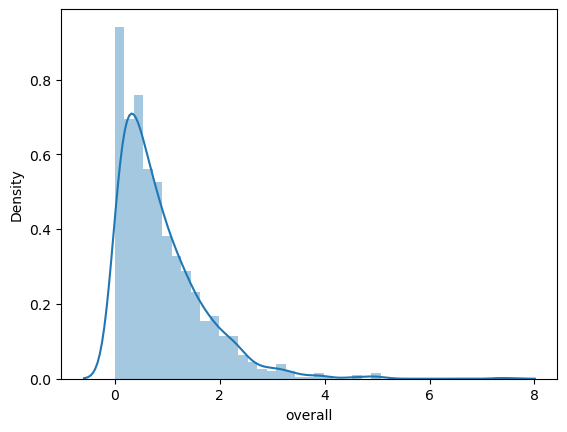

In [14]:
y_pred = model3.predict(Xtest)

point_est = MAE(ytest, y_pred)
abs_error = np.abs(ytest - y_pred)

confidence_int = (np.quantile(abs_error, 0.025), np.quantile(abs_error, 0.975))

print('My point estimate is', point_est)
print('My confidence interval is between', confidence_int[0], 'and', confidence_int[1])

sns.distplot(abs_error)

**Answer a) Based on the cross validation errors, the model I would choose is the third model where we consider the features as polynomials.**


**Answer b) The test error, and the cross validation are very close, this is likely the case because both scores indicate the performance of the model. Additionally, the cross validation score is used to improve the model, and when checking these improvements using the test set, we find similar accuracies because of the model's ability to perform consistently among different datasets.**

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.